In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from utils.empirical_data import *
from utils.optimized_random_response import *
from utils.randomized_response import *
from utils.repetitive_optimizer import *
from utils.synthetic_dataset import *
from utils.exponential_mechanism import *
from utils.simpleinfotheory import *
from utils.normalize_error_matrix import *
from utils.rappor_mechanism import *

import matplotlib as mpl
import matplotlib.lines as mlines

mpl.rcParams.update({'font.size': 16})

In [16]:
from utils.alphabet import *

NUM_ATTRIBUTES = 2
NUM_STATES = [10, 10]
DATASET_SIZE = 50000

priority_dict = {} # {'0': 2, '1': 0.5}

TOTAL_STATES = 1
alphabet_dict = {}
for i in range(NUM_ATTRIBUTES):
    TOTAL_STATES *= NUM_STATES[i]
    alphabet_dict[str(i)] = np.arange(NUM_STATES[i])

ALL_ALPHABET = create_alphabet(attributes_with_alphabet=alphabet_dict)
STRING_ALL_ALPHABET = convert_alphabet_to_string(ALL_ALPHABET)
ATTRIBUTE_LIST = list(alphabet_dict.keys())

random_dist = np.ones(TOTAL_STATES) # np.array([random.randint(1, 5000) for i in range(TOTAL_STATES)]) # np.ones(TOTAL_STATES) #
random_dist = random_dist/np.sum(random_dist)
# random_dist = np.array([0.3, 0.01, 0.01, 0.01, 0.30, 0.01, 0.01, 0.01, 0.34])
synthetic_dataset_constructor = Gen_Synthetic_Dataset(no_of_states = TOTAL_STATES, no_of_samples = DATASET_SIZE, alphabet=STRING_ALL_ALPHABET)
correlated_synthetic_dataset = synthetic_dataset_constructor.gen_custom(distribution=random_dist)


In [17]:
alphabet_dict

{'0': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 '1': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [18]:
def mutual_info_pair(a, b):
    return mutualinformationempirical(xn=a, yn=b)[0]

# I(A;A',B') = I(A;A') + I(A;B'|A')

def conditional_mutual_info(a, b, c):
    return conditionalmutualinformationempirical(a, b, c)

def total_info_leakage(A, A_prime, B_prime):
    return conditional_mutual_info(A, B_prime, A_prime) # mutual_info_pair(A, A_prime) + conditional_mutual_info(A, B_prime, A_prime)
    # return  mutual_info_pair(A, B_prime) - conditional_mutual_info(A, B_prime, A_prime)

def mutual_information(a, b):
    processed_a = []
    # print(a)
    # print(b)
    for i in a:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_a.append(np.array(actual))
    processed_a = np.array(processed_a)
    processed_b = []
    
    for i in b:
        actual_split = i.split(" ")
        actual = []
        # print(actual_split)
        for j in actual_split:
            # print(i)
            if j != "" :
                actual.append(int(j))
        processed_b.append(np.array(actual))
    processed_b = np.array(processed_b)

    mi = []
    # print("processed_a", processed_a)
    # print("processed_b", processed_b)
    # for i in range(np.shape(processed_b)[1]):
    #     mi.append(mutual_info_pair(processed_a[:,i], processed_b[:,i]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_a[:,1]))
    mi.append(mutual_info_pair(processed_b[:,1], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,0], processed_b[:,0]))
    # mi.append(mutual_info_pair(processed_a[:,1], processed_b[:,1]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,0], processed_b[:,1]))
    # mi.append(total_info_leakage(processed_a[:,1], processed_b[:,1], processed_b[:,0]))
    # mi.append(total_info_leakage(processed_a[:,0], processed_b[:,1], processed_b[:,0]))
    return mi
    

In [19]:
EPS_ARRAY = np.arange(30)*0.20#np.arange(50)*0.15

alphabet  100 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [5 9]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]
alphabet_dict  2 {'0': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), '1': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
prior_dist  100 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 

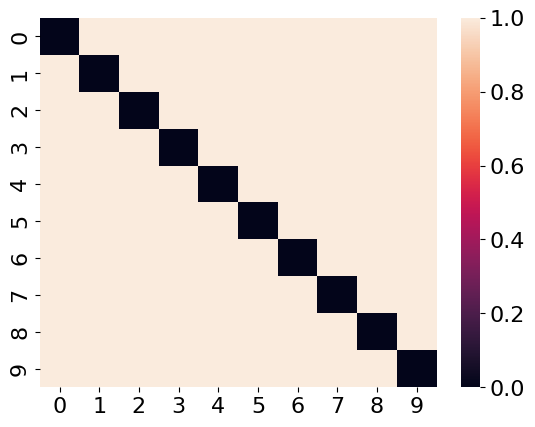

conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
individual_alphabet  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


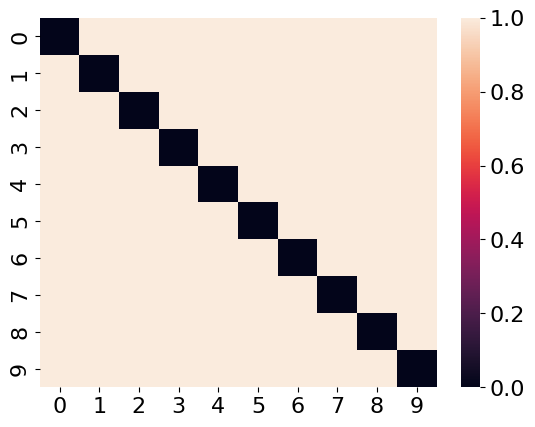

conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


[{'0': <utils.optimized_random_response.Optimized_Randomized_Response at 0x127d0edc0>},
 {'0 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x127aa3c70>,
  '1 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1310efdc0>,
  '2 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x140a8ce80>,
  '3 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409c73d0>,
  '4 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409da5b0>,
  '5 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409c78b0>,
  '6 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x140a8c580>,
  '7 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409d9fd0>,
  '8 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409dabe0>,
  '9 ': <utils.optimized_random_response.Optimized_Randomized_Response at 0x1409d9640>}]

In [20]:
def get_mechanism_key(predessor_index_list):
    __key = ""
    for i in predessor_index_list:
        __key += str(i) + " "
    return __key

def string_to_list(s):
    l = []
    actual_split = s.split(" ")
    for j in actual_split:
        if j != "" :
            l.append((j))
    return l

def get_conditional_dist(attribute_num, predessor_index_list, individual_alphabet, global_alphabet, prior_dist):
    __marginal_prob_dist = []
    k = len(predessor_index_list)
    # print("predessor_index_list ", predessor_index_list)
    for i in individual_alphabet:
        __marginal_prob = 0
        for index_j, j in enumerate(global_alphabet):
            # print("j[:k] ", j[:k], j[:k] == predessor_index_list)
            if j[attribute_num] == i and (k == 0 or j[:k] == predessor_index_list):
                __marginal_prob += prior_dist[index_j]
        __marginal_prob_dist.append(__marginal_prob)
    return __marginal_prob_dist/sum(__marginal_prob_dist)


def create_optimal_mechnism_dict(alphabet = [], alphabet_dict = {}, prior_dist = [], err_type = "0_1"):
    mechanism_list = []
    print("alphabet ", len(alphabet), alphabet)
    print("alphabet_dict ", len(alphabet_dict), alphabet_dict)
    print("prior_dist ", len(prior_dist), prior_dist)
    for i in range(NUM_ATTRIBUTES):
        mechanism_dict = {}
        individual_alphabet = alphabet_dict[str(i)]
        print("individual_alphabet ", convert_alphabet_to_string(individual_alphabet))
        state_count = len(individual_alphabet)
        normalize_error_matrix = Normalize_error_matrix(attribute_list=[str(i)], alphabet=individual_alphabet, priority_dict=priority_dict, alphabet_dict=alphabet_dict, err_type=err_type)
        err_matrix = normalize_error_matrix.normalized_error_matrix
        sns.heatmap(err_matrix)
        plt.show()
        for index_j, j in enumerate(alphabet):
            predessor_index_list = j[:i]
            if len(predessor_index_list) == 0:
                conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_1 = err_matrix*(1- conditional_prior_dist) #(1/(conditional_prior_dist+0.00000001))
                # err_matrix_1 = err_matrix_1 / np.max(err_matrix_1)
                # sns.heatmap(err_matrix_1)
                # plt.show()
                print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict["0"] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
                break
            __key = get_mechanism_key(predessor_index_list = predessor_index_list)
            # print(__key)
            if __key not in mechanism_dict.keys():
                conditional_prior_dist = get_conditional_dist(i, predessor_index_list, (individual_alphabet), alphabet, prior_dist)
                # err_matrix_2 = err_matrix*(1- conditional_prior_dist) # *(1/(conditional_prior_dist+0.00000001))
                # err_matrix_2 = err_matrix_2 / np.max(err_matrix_2)
                # sns.heatmap(err_matrix_2)
                # plt.show()
                print("conditional_prior_dist ", len(conditional_prior_dist), conditional_prior_dist)
                # conditional_prior_dist = np.ones(len(conditional_prior_dist))/len(conditional_prior_dist)
                optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = conditional_prior_dist, STATE_COUNT = state_count, INPUT_ALPHABET = convert_alphabet_to_string(individual_alphabet), normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=False)
                mechanism_dict[__key] = optimal_random_response_mechanism
                # sns.heatmap(optimal_random_response_mechanism.get_mechanism(2), annot=True)
                # plt.show()
        mechanism_list.append(mechanism_dict)
    return mechanism_list

def get_randomized_value(actual_value, eps, mechanism_list):
    actual_value = string_to_list(actual_value)
    last_value = None
    randomized_value_list = ""
    # print("actual_value ", actual_value)
    for index_i, i in enumerate(actual_value):
        if last_value == None:
            last_value = mechanism_list[index_i]["0"].gen_random_output(actual_value=i, eps=eps)[0]
        else:
            __key = randomized_value_list  #get_mechanism_key(predessor_index_list=randomized_value_list)
            last_value = mechanism_list[index_i][__key].gen_random_output(actual_value=i, eps=eps)[0]
        randomized_value_list += last_value + " "
    return randomized_value_list

            
create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type="0_1")

{'[0 0]': 0, '[0 1]': 1, '[0 2]': 2, '[0 3]': 3, '[0 4]': 4, '[0 5]': 5, '[0 6]': 6, '[0 7]': 7, '[0 8]': 8, '[0 9]': 9, '[1 0]': 10, '[1 1]': 11, '[1 2]': 12, '[1 3]': 13, '[1 4]': 14, '[1 5]': 15, '[1 6]': 16, '[1 7]': 17, '[1 8]': 18, '[1 9]': 19, '[2 0]': 20, '[2 1]': 21, '[2 2]': 22, '[2 3]': 23, '[2 4]': 24, '[2 5]': 25, '[2 6]': 26, '[2 7]': 27, '[2 8]': 28, '[2 9]': 29, '[3 0]': 30, '[3 1]': 31, '[3 2]': 32, '[3 3]': 33, '[3 4]': 34, '[3 5]': 35, '[3 6]': 36, '[3 7]': 37, '[3 8]': 38, '[3 9]': 39, '[4 0]': 40, '[4 1]': 41, '[4 2]': 42, '[4 3]': 43, '[4 4]': 44, '[4 5]': 45, '[4 6]': 46, '[4 7]': 47, '[4 8]': 48, '[4 9]': 49, '[5 0]': 50, '[5 1]': 51, '[5 2]': 52, '[5 3]': 53, '[5 4]': 54, '[5 5]': 55, '[5 6]': 56, '[5 7]': 57, '[5 8]': 58, '[5 9]': 59, '[6 0]': 60, '[6 1]': 61, '[6 2]': 62, '[6 3]': 63, '[6 4]': 64, '[6 5]': 65, '[6 6]': 66, '[6 7]': 67, '[6 8]': 68, '[6 9]': 69, '[7 0]': 70, '[7 1]': 71, '[7 2]': 72, '[7 3]': 73, '[7 4]': 74, '[7 5]': 75, '[7 6]': 76, '[7 7]':

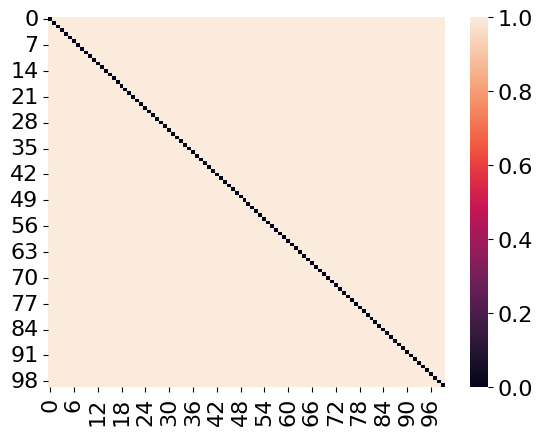

alphabet  100 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [5 9]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]
alphabet_dict  2 {'0': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), '1': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
prior_dist  100 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 

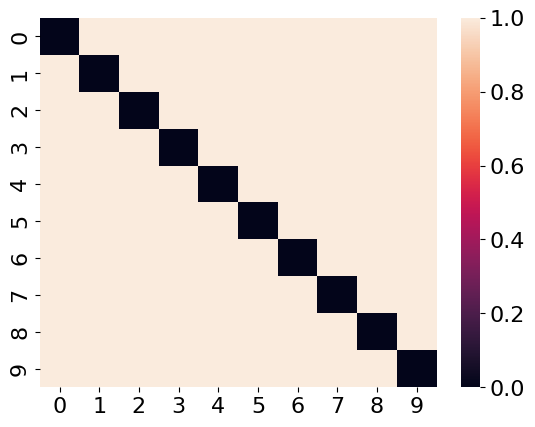

conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
individual_alphabet  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


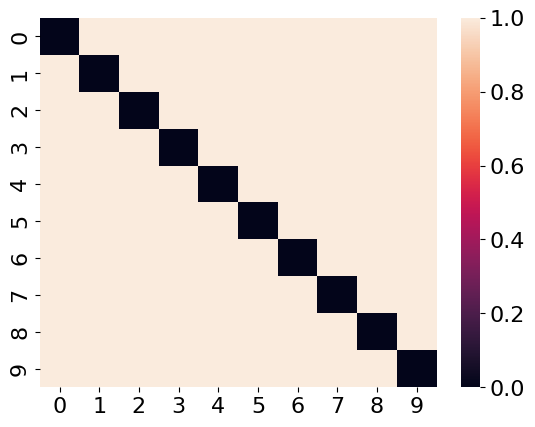

conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
conditional_prior_dist  10 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.30000000000000004
0.3000000000000000

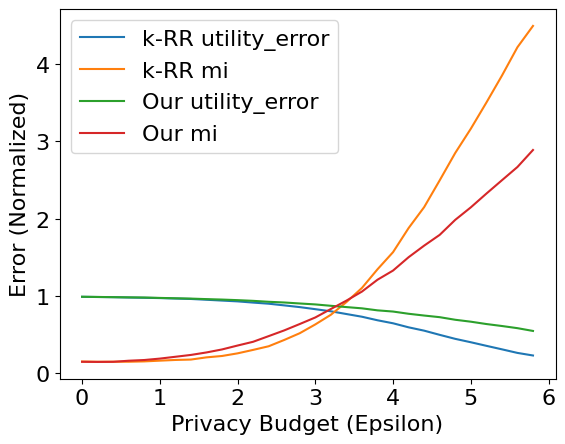

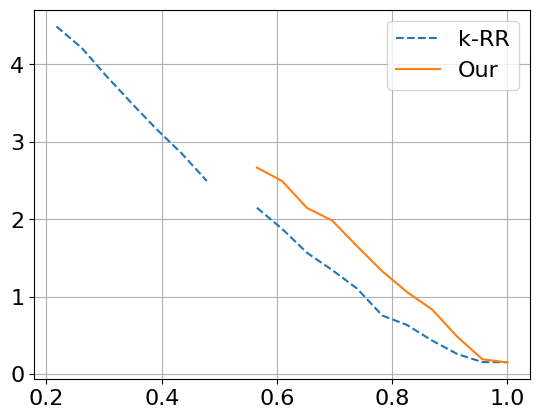

In [21]:
utility_error_function = ["0_1"] # ["0_1", "l1", "l2"]
line_styles = {"RAPPOR": ":", "k-RR": "--", "Exponential": "-.", "Our": "-", "optimal": ":", "k-RR_divided": "-"}

for util_err in utility_error_function:
    alphabet_value_dict = {}
    for i in range(len(ALL_ALPHABET)):
        alphabet_value_dict[str(ALL_ALPHABET[i])] = i
    print(alphabet_value_dict)
    normalize_error_matrix = Normalize_error_matrix(attribute_list=ATTRIBUTE_LIST, alphabet=ALL_ALPHABET, priority_dict=priority_dict, alphabet_dict=alphabet_value_dict, err_type=util_err)
    err_matrix = normalize_error_matrix.normalized_error_matrix
    sns.heatmap(err_matrix)
    plt.show()

    # exponential_mechanism_without_prior = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=True)

    # exponential_mechanism_with_prior = Exponential_mechanism(prior_dist=random_dist, STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix, only_err_matrix=False)
    optimal_random_response_mechanism = Optimized_Randomized_Response(prior_dist = random_dist, STATE_COUNT = TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, normalized_objective_err_matrix = err_matrix, 
                    TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "SCS", is_kl_div = True, ALPHA=0.01, accelerate_from_rr=True)

    random_response_mechanism = Randomized_Response(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET=STRING_ALL_ALPHABET, normalized_objective_err_matrix=err_matrix)
    optimal_mechanism_list = create_optimal_mechnism_dict(alphabet=ALL_ALPHABET, alphabet_dict=alphabet_dict, prior_dist=random_dist, err_type=util_err)

    # rappor_mechanism = Rappor_mechanism(STATE_COUNT=TOTAL_STATES, INPUT_ALPHABET = STRING_ALL_ALPHABET, prob_f=0.5, prob_p=0.25, prob_q=0.75, collection_count = 20)
    # mechanisms_dict = {"Exp. mechanism without prior": exponential_mechanism_without_prior, "Exp. mechanism with prior": exponential_mechanism_with_prior, "k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}
    # mechanisms_dict = {"k-RR": random_response_mechanism, "Optimal k-RR": optimal_random_response_mechanism}
    # mechanisms_dict = {"RAPPOR": rappor_mechanism, "k-RR": random_response_mechanism, "Exponential": exponential_mechanism_without_prior, "Our": optimal_random_response_mechanism}
    mechanisms_dict = {"k-RR": random_response_mechanism, "Our": optimal_mechanism_list, "k-RR_divided": random_response_mechanism_divided}

    error_dict = {}
    mi_dict = {}
    total_mi_dict = {}

    for key in list(mechanisms_dict.keys()):
        error_dict[key] = []
        mi_dict[key] = []
        total_mi_dict[key] = []

    for eps in EPS_ARRAY:
        # print(eps)
        for mechanism in list(mechanisms_dict.keys()):
            __tot_error = 0
            __perturbed_value_list = []
            for entry in correlated_synthetic_dataset:
                # entry = entry_np_value[0]
                if mechanism == "Our":
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps/2, mechanism_list=optimal_mechanism_list))
                    # print("__perturbed_value_list ", __perturbed_value_list[-1])
                elif mechanism == "k-RR_divided":
                    __perturbed_value_list.append(get_randomized_value(actual_value=entry, eps=eps/2, mechanism_list=optimal_mechanism_list))
                    # print("__perturbed_value_list ", __perturbed_value_list[-1])
                elif mechanism == "RAPPOR":
                    __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps, prob_f=eps/10, is_eps=True)[0])
                else:
                    __perturbed_value_list.append(mechanisms_dict[mechanism].gen_random_output(actual_value=entry, eps=eps)[0])
                # print(entry,__perturbed_value_list[-1])
                __error = normalize_error_matrix.get_value_error(actual=entry, perturbed=__perturbed_value_list[-1])
                __tot_error += __error
            error_dict[mechanism].append(__tot_error/len(correlated_synthetic_dataset))
            mi_dict[mechanism].append(mutual_info_pair(correlated_synthetic_dataset, __perturbed_value_list))
            # total_mi_dict[mechanism].append(total_info_leakage(correlated_synthetic_dataset, __perturbed_value_list, ))
            # mi_dict[mechanism].append(mutual_information(correlated_synthetic_dataset, __perturbed_value_list))

            # if mechanism == "Optimal k-RR":
            #     optimal_mechanism = mechanisms_dict[mechanism].get_mechanism(eps=eps)
                
                # posterior_prob_distribution = np.zeros(TOTAL_STATES)
                # posterior_joint_prob = np.zeros((TOTAL_STATES, TOTAL_STATES))
                # for i in range(TOTAL_STATES):
                #     posterior_joint_prob[:,i] = np.reshape(optimal_mechanism[:,i] * np.array(random_dist), (4,))
                #     posterior_prob_distribution[i] = np.sum(optimal_mechanism[:,i] * np.array(random_dist))
                # print("posterior_prob_distribution ", posterior_prob_distribution)
                # print("Distance ", np.linalg.norm((random_dist-posterior_prob_distribution), 2))
                # sns.heatmap(optimal_mechanism)
                # plt.show()
    lagends = []
    for mechanism in list(mechanisms_dict.keys()):
        lagends.append(mechanism + " utility_error")
        plt.plot(EPS_ARRAY, error_dict[mechanism])
        # lagends.append(mechanism + " info_leakage")
        # plt.plot(EPS_ARRAY, mi_dict[mechanism])
        # lagends.append(mechanism + " total_info_leakage")
        # plt.plot(EPS_ARRAY, total_mi_dict[mechanism])
        # for mi_ in range(len(mi_dict[mechanism][0])):
        lagends.append(mechanism + " mi")
        plt.plot(EPS_ARRAY, np.array(mi_dict[mechanism]))
        #     lagends.append(f"{mechanism}")
            # legend.append(f"MI for Optimal, attr:{grouped_attributes_list[i][mi_]}")

    plt.legend(lagends)
    plt.xlabel("Privacy Budget (Epsilon)")
    plt.ylabel("Error (Normalized)")
    # plt.title(f"{error_cal_type} error between original value and perturbed value for {Attr_list}")
    plt.show()

    utility_error = np.arange(24)
    
    utility_error = utility_error/np.max(utility_error)

    tolerance = (utility_error[1] - utility_error[0])/2

    info_dict = {}

    for mechanism in list(mechanisms_dict.keys()):
        info_dict[mechanism] = []
        for i in utility_error:
            info_dict[mechanism].append(np.nan)

    for index_1, i in enumerate(utility_error):
        for mechanism in list(mechanisms_dict.keys()):
            for index_, j in enumerate(error_dict[mechanism]):
                if abs(i-j) < tolerance:
                    info_dict[mechanism][index_1] = (mi_dict[mechanism][index_])
                    break
    fig = plt.figure()
    lagends = []
    for mechanism in list(mechanisms_dict.keys()):
        lagends.append(mechanism)
        plt.plot(utility_error, info_dict[mechanism], linestyle=line_styles[mechanism])

    plt.legend(lagends)
    plt.grid(visible=True)
    plt.show()
    fig.savefig(f"{util_err}.pdf", bbox_inches='tight')
